/home/harry/anaconda3/envs/capsuleNetwork/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.

/home/harry/PycharmProjects/capsuleNetwork/Multi-Layer-Capsule-Network/capsnet.py:86: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/home/harry/anaconda3/envs/capsuleNetwork/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:40: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




Test Accuracy = 98.79 %
Training Graph Created
Accuracy Graph Created


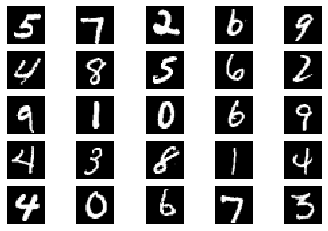

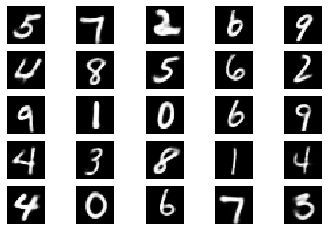

In [3]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from make_graph import plot_graph, generate_reconstructions
from capsnet import CapsuleNetwork, CapsuleLoss
import numpy as np
import time

device = 'cuda'

transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST("MNIST_data/", transform=transform, download=True, train=True)
testset = datasets.MNIST("MNIST_data/", transform=transform, download=True, train=False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

model = CapsuleNetwork()
model.to(device)

optimizer = optim.Adam(model.parameters())
loss_function = CapsuleLoss()
epochs = 50
overall_training_accuracy = []
overall_training_loss = []
mode = "Test" # {"Train", "Test", "VPA"}

if mode == "Train":
  for epoch in range(epochs):
    start_time = time.time()
    running_loss = 0
    training_accuracy = 0
    count = 0
    percent = 0
    for images, raw_labels in iter(trainloader):
      count += 1
      # Generate One Hot encodings of labels
      labels = torch.eye(10).index_select(dim=0, index=raw_labels)
      class_probabilities, reconstructions = model(images.to(device), labels.to(device))
      # Compute Loss and Gradients
      loss = loss_function(images.to(device), reconstructions, labels.to(device), class_probabilities)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      _, logits = class_probabilities.topk(k=1, dim=1)
      # Calculate Accuracy
      training_accuracy_tensor = logits.view(*raw_labels.shape) == raw_labels.to(device)
      training_accuracy += torch.mean(training_accuracy_tensor.type(torch.FloatTensor))
      if(count % (int(len(trainloader)/10)+1) == 0):
        percent += 10
        print("%d %% Complete" % (percent))
    percent += 10
    print("%d %% Complete" % (percent))
    training_loss = running_loss / len(trainloader)
    training_accuracy = training_accuracy * 100 / len(trainloader)
    elapsed_time = time.time() - start_time
    print("Epoch %d / %d:" % (epoch+1, epochs))
    print("Time Elapsed = %d s" % (elapsed_time))
    print("Training Loss = %f" % (training_loss))
    print("Training Accuracy = %0.2f %%" % (training_accuracy))
    if ((epoch+1) % 10 == 0):
      print("Generate Reconstructions:")
      generate_reconstructions(reconstructions[:10].cpu(), images[:10].cpu(), epoch+1)
      print("Reconstructions Generated")
    overall_training_accuracy.append(training_accuracy)
    overall_training_loss.append(training_loss)
    history = {
      "train_loss": overall_training_loss,
      "train_accuracy": overall_training_accuracy
    }
  np.save("history.npy", history)
  torch.save(model, "model_50.pth") 

elif mode == "Test":
  # Testing
  testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=100)
  loaded_model = torch.load("model_50.pth")
  loaded_model.to(device)
  loaded_model.eval()
  testing_accuracy = 0

  for images, labels in iter(testloader):
      class_probabilities, reconstructions = loaded_model(images.to(device))
      _, logits = class_probabilities.topk(k=1, dim=1)
      testing_accuracy_tensor = logits.view(*labels.shape) == labels.to(device)
      testing_accuracy += torch.mean(testing_accuracy_tensor.type(torch.FloatTensor))
  testing_accuracy = testing_accuracy * 100 / len(testloader)                                   
  print("Test Accuracy = %0.2f %%" % (testing_accuracy))                           
  generate_reconstructions(reconstructions.cpu(), images.cpu(), "Test")
  plot_graph(testing_accuracy)

elif mode == "VPA":
  # Vector Perturbation Analysis
  loaded_model = torch.load("model_50.pth")
  loaded_model.eval()
  test_indices = list(range(0, 11))
  # Create a batch size of 11
  test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)
  testloader = torch.utils.data.DataLoader(testset, sampler=test_sampler, batch_size=11)
  # Vector Perturbation Analysis
  for images, _ in iter(testloader):
    _, reconstructions = loaded_model(images.to(device), pose=True)
  generate_reconstructions(reconstructions.cpu())